# Lineare Regression

## Wat is het?

Lineare regression is een Machine Learning techniek dat zoekt naar het verband tussen een set features en een target of output waarde.
Omdat voor de training van het model de output-waarde gebruikt wordt van elk voorbeeld/training example voor het bepalen van het beste model (minimaliseren kostenfunctie) valt deze technieke binnen het gebied van supervised learning. 

In deze notebook wordt deze technieke uitgelegd en gedemonstreerd door middel van een voorbeeld dataset die we hieronder gaan genereren.
In het begin gaan we werken met 1 feature maar in de praktijk is er geen limiet op hoeveel features er kunnen zijn. 
Het algoritme dat we hier gaan gebruiken gaat blijven werken maar meer features zorgen er wel voor dat er meer data/ examples beschikbaar moeten zijn omdat het verband moeilijker te vinden is. 
Dit zorgt er dan ook voor dat het veel langer kan duren voor het model te trainen.

In [3]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# graphical
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from ipywidgets import interact, FloatSlider
import matplotlib.animation as animation

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

## Demo-data

Eerst gaan we een demo-dataset aanmaken waarop we gaan lineare regressie toepassen. Dit kan door middel van onderstaande functie die 5 parameters heeft:
* a = de richtingscoefficient van de gewenste data
* b = de bias / verticale verschuiving van de gewenste data
* xmin = de minimum waarde op de x-as
* xmax = de maximum waarde op de x-as
* noise = de maximum afwijking van elk datapunt ten opzichte van de rechte

In [4]:
def generate_data_single_feature(a, b, xmin, xmax, N, noise):
    x = np.random.uniform(low=xmin, high=xmax, size=(N,))
    y = [a*i+b + np.random.uniform(low = -noise, high=noise) for i in x] # make data from equation and add noise
    
    return pd.DataFrame({"feature": x, "output":y})

In [5]:
data = generate_data_single_feature(10, 50, 0, 20, 100, 30)
data.head(10)

,feature,output
0,6.092041,82.356997
1,9.301344,121.960405
2,6.161703,115.956510
3,1.558518,69.670031
4,14.147422,163.778439
5,1.505071,93.816087
6,8.269224,137.696993
7,15.076338,195.148640
8,13.086715,187.174802
9,19.971709,232.642331


<Axes: xlabel='feature', ylabel='output'>

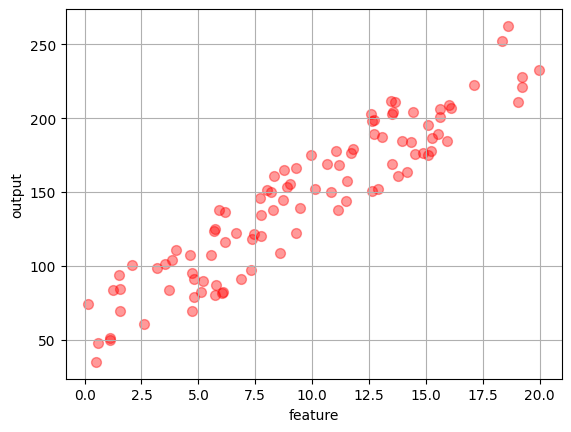

In [6]:
data.plot(kind='scatter',x='feature',y='output',grid=True,s=50,color='red', alpha=0.4)

## Wat is het beste model?

Lineare Regressie gaat nu op zoek naar de beste lijn/curve/... die de beste match is voor dit model.
Voor deze dataset zijn we op zoek naar een rechte dus de vergelijking voor deze rechte kunnen we schrijven als:

$ f_{\pmb{w}}(x) = w_0 + w_1 x$ = **target**

In deze vergelijingen worden $w_0$ en $w_1$ de gewichten of parameters genoemd van het model.
Deze kunnen ook als vector $\pmb{w}$ voorgesteld worden.
Regressie gaat dan op zoek naar de optimale waarden van deze gewichten.
Dit gebeurt door **training** of **learning** van het model.

Hoe bepaal je echter welke lijn het beste is? Welk van onderstaande lijnen is de beste match?

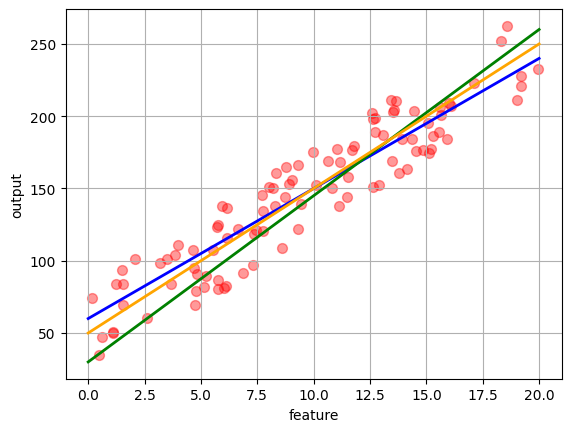

In [7]:
data.plot(kind='scatter',x='feature',y='output',grid=True,s=50,color='red', alpha=0.4)
plt.plot([0, 20], [60, 240], color='blue', lw=2)
plt.plot([0, 20], [30, 260], color='green', lw=2)
plt.plot([0, 20], [50, 250], color='orange', lw=2)

Om te bepalen welke rechte de beste is voor deze dataset moeten we gebruik maken van een kostenfunctie.
Deze functie berekent voor elke combinatie van gewichten een bepaalde kost.
Het optimaliseren van de gewichten komt dan overeen met het minimaliseren van de kost functie / het zoeken van de gewichten met een minimale kost.

Een veelgebruikte kostfunctie $L(\pmb{w})$ bij Lineare Regressie is Least Mean Squares (of het gemiddelde van de fout). De vergelijking van deze kostfunctie is:

$ L(\pmb{w}) = \frac{1}{2N}\sum\limits_{i=1}^{N} (f_{\pmb{w}}(x^i) - y^i)^2$

Hier wordt $L$ gebruikt als notatie voor de kostenfunctie omdat deze ook vaak Lossfunction genoemd wordt.
In deze vergelijking stelt $\pmb{w}$ de gewichten voor, $x^i$ en $y^i$ respectievelijk de input en output van het $i$-de trainingsexample en $N$ het totaal aantal trainings examples.
Merk op dat het belangrijk is om het gemiddelde van de totale fout te gebruiken (delen door $N$) omdat anders de fout afhankelijk is van het totaal aantal trainingsexamples.
Een tweede opmerking is dat de extra deling door 2 enkel wiskundig belangrijk is omdat hier later de afgeleide moet van genomen worden. 
Al deze wiskunde moet je niet kunnen uitvoeren of programmeren.
Dit gebeurd achter de schermen door de verschillende libraries die we gaan gebruiken.

1     None
96    None
59    None
78    None
93    None
22    None
97    None
28    None
51    None
61    None
dtype: object

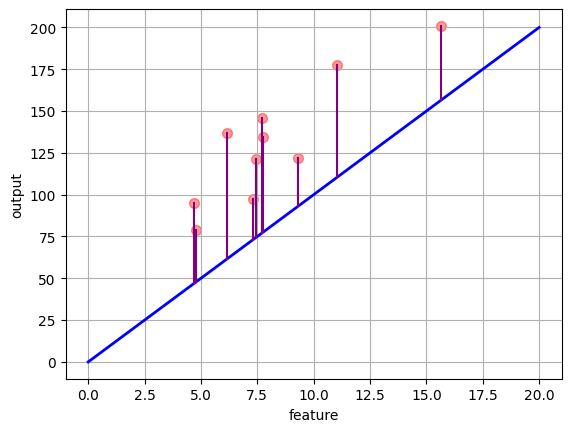

In [8]:
s = data.sample(10)
s.sample(10).plot(kind='scatter',x='feature',y='output',grid=True,s=50,color='red', alpha=0.4)
plt.plot([0, 20], [0, 200], color='blue', lw=2)

def draw_error(row):
    plt.plot([row.feature, row.feature], [row.output, row.feature*10], color="purple")

s.apply(draw_error, axis=1)


Bij het zoeken naar de beste rechte kunnen we twee gewichten aanpassen om de kostenfunctie te minimaliseren, namelijk de richtingscoefficient en de verschuiving. 
Met de onderstaande code kunnen deze gewichten manueel veranderd worden.
Zoek nu eens zelf naar de optimale waarden.

In [9]:
%matplotlib inline
def LMS(x,y,w0, w1):
    pred = x*w1+w0
    return ((y - pred)**2).sum() / 2 / len(x)  

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.tight_layout()

def setWeights(w0, w1):
    lms_w1 = LMS(data.feature, data.output, w0, w1)
    lms_xAxis = np.linspace(-20, 50, 100)
    lms_yAxis = np.array([LMS(data.feature, data.output, w0, w1tmp) for w1tmp in lms_xAxis])
    
    ax1 = axes[0]
    ax1.clear()
    ax1.plot(w1, lms_w1, 'ro')
    ax1.plot(lms_xAxis, lms_yAxis)
    ax1.set_xlabel('w1')
    ax1.set_ylabel('Loss')
    ax1.set_title('LMS - cost')
    
    ax2 = axes[1]
    ax2.clear()
    xAxis = np.array([data.feature.min(), data.feature.max()])
    yAxis = w0 + xAxis * w1
    ax2.scatter(data.feature, data.output)
    ax2.plot(xAxis, yAxis, 'r')
    ax2.set_ylim(0, 300)
    ax2.set_xlabel('feature')
    ax2.set_ylabel('output')
    
    fig.canvas.draw_idle()
    plt.show()

interact(setWeights, w0=FloatSlider(min=-100, max=100.0, step=1, value=0), w1=FloatSlider(min=-20, max=50, step=1, value=0))

interactive(children=(FloatSlider(value=0.0, description='w0', min=-100.0, step=1.0), FloatSlider(value=0.0, d…

<function __main__.setWeights(w0, w1)>

Dit is eigenlijk net hetzelfde wat excel doet als er een trendlijn bepaalt wordt door de punten. Echter Excel kan dit enkel doen bij eenvoudige verbanden en loopt vast als het om complexere datasets gaat.

Het voorgaande toonde enkel 1 gewicht op de x-as omdat het een 2D-plot was.
Met behulp van een 3D-plot kan de totale kostenfunctie getoond worden.

In [10]:
w0_x = np.linspace(-100,100,100)
w1_x = np.linspace(-20,20,100)
lms_y = np.array([
    [LMS(data.feature, data.output, w0, w1) for w1 in w1_x]
    for w0 in w0_x
])

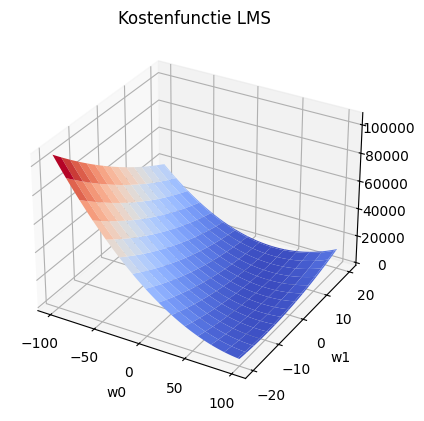

In [11]:
x ,y = np.meshgrid(w0_x, w1_x)

fig3D = plt.figure()
axis3D = fig3D.add_subplot(111, projection='3d')
axis3D.plot_surface(x, y, lms_y, rstride=7, cstride=7,cmap=cm.coolwarm)
axis3D.set_xlabel('w0')
axis3D.set_ylabel('w1')
axis3D.set_title('Kostenfunctie LMS');

## Hoe vinden van de optimale gewichten

Hoe kunnen nu met behulp van deze kostenfunctie, de laagste kost gevonden worden?
Algebraisch uitrekenen met behulp van matrices is een mogelijkheid tot als je werkt met heel veel features.
Een andere mogelijkheid is door gebruik te maken van gradient descent.
Dit is het grote achterliggende idee van heel veel verschillende Machine Learning technieken dus is het belangrijk om te weten hoe dit werkt.

### Gradient Descent

In plaats van onmiddelijk de meest optimale waarde uit te rekenen zoals bij de algebraische methode, wordt er in deze manier stapje per stapje geoptimaliseerd op basis van de kostenfunctie.

Waar is bijvoorbeeld het laagste punt op onderstaande foto? Hoe zou je ernaar toe gaan?
![dal](images/dal.jpg)

Je weet dat je op ergens op de berg begint maar je weet niet exact waar je naartoe moet. 
Je kijkt dus rond je en wandelt in de richting die het snelst naar beneden gaat. 
Dit is eigenlijk net wat Gradient Descent doet. 
Er wordt begonnen op een willekeurige plaats en afhankelijk van de helling (afleiding) van de kostenfunctie worden de gewichten aangepast.
Deze aanpassing gebeurt door gebruik te maken van de onderstaande formules

$ \frac{dL(\pmb{w})}{dw_0} = \frac{1}{N}\sum\limits_{i=1}^{N} (w_1x^i + w_0 - y^i)$

$ \frac{dL(\pmb{w})}{dw_1} = \frac{1}{N}\sum\limits_{i=1}^{N} (w_1x^i + w_0 - y^i)x^i$

$w_0 = w_0 - \eta \frac{dL(\pmb{w})}{dw_0}$

$w_1 = w_1 - \eta \frac{dL(\pmb{w})}{dw_1}$

waarin $\eta$ de learning rate voorstelt.

**Kan je door deze manier te gebruiken vast komen te zitten in een lokaal minimum?**

De meeste klassieke technieken in Machine Learning hebben geen last van lokale minima en vinden onmiddelijk het globale minimum.
Dit komt omdat de kostenfunctie gebruikt in deze algoritmes convex is. 
Er zijn dus geen plotselinge stijgingen halverwege de daling wat voor lokale minima kan zorgen.

#### Learning rate

Dat bepaalt hoe snel je evolueert naar het optimum.
Een goede keuze voor deze parameter is belangrijk:
* te klein, dan duurt het zeer lang voor je het optimum bereikt
* te groot, dan kan het zijn dat je steeds over het minimum springt waardoor het ook lang kan duren.
* in het begin groot en later traag of een variabele learning rate zorgt voor een goede combinatie van de twee.

Door veel van de algoritmes wordt de learning rate zelf aangepast zodat als ze merken dat je overshoot of dat je het optimum benaderd dat de learning rate verlaagd wordt.

![learning rate](images/learningrate.png)

#### Training van het model door middel van bestaande libaries

Natuurlijk zou je bovenstaande formules zelf kunnen implementeren in python om zou je model te trainen, maar gelukkig is dit niet nodig omdat dit algoritme reeds geimplementeerd is door de libary [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).
Het trainen van de verschillende technieken in deze library volgt grotendeels hetzelfde stramien. 
Eerst moet het gewenste algoritme opgezet worden en eventueel een aantal parameters gekozen worden. 
Daarna wordt het model getrained met een **fit** methode.
Een getrained model kan je daarna gebruiken om voorspellingen te doen.

In [12]:
model = LinearRegression()
model.fit(pd.DataFrame(data.feature), data.output)
predicts = model.predict(np.array([0, 10, 20]).reshape(-1, 1))
model.score(np.array([0, 10, 20]).reshape(-1, 1), predicts)

/usr/local/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


1.0

## Enkelvoudige naar meervoudige regressie

In de praktijk zullen er bitter weinig situaties zijn waar een variabele voorspeld kan en moet worden door 1 feature.
* Kwaliteit van wijn hangt af van zuurtegraad, suikergehalte, dichtheid, alcohol percentage, bewaringstemperatuur
* Warmteverlies van het huis op basis van aantal vensters, type glas, muurisolatie, dakisolatie, ...

Gelukkig is het bovenstaande eenvoudig uit te breiden naar meerdere features.
Per extra feature gaat er nog 1 extra gewicht bij komen.

**Waarom moeten er geen twee gewichten bijkomen?**

Dit komt omdat de gewichten die de verschuiving bijhouden kunnen samengevoegd worden tot 1 gewicht.

De formule voor $f_{\pmb{w}}(x)$ ziet er dan als volgt uit voor het geval met $n$ features:

$f_{\pmb{w}} = w_0 + w_1 x_1 + w_2x_2 + \dots + w_n x_n$

Het eindresultaat is dus een lineaire combinatie van alle features

In [13]:
def generate_data_multi_feature(coeffs, b, mins, maxs, N, noise):
    result = pd.DataFrame()
    result["y"] = np.random.uniform(low = -noise, high=noise, size=(N,)) + b
    for i, coeff in enumerate(coeffs):
        col = "x_" + str(i)
        result[col] = np.random.uniform(low=mins[i], high=maxs[i], size=(N,))
        result["y"] =result["y"] + result[col] * coeff
    
    return result

data_3 = generate_data_multi_feature([10,5,-9], 30, [-10, -5, 0], [0, 8, 17], 1000, 10)
data_3.head()

,y,x_0,x_1,x_2
0,-61.327356,-6.884848,1.114614,2.121394
1,-8.074509,-0.772515,-0.397410,3.135801
2,-61.889420,-0.492457,-2.569743,9.091003
3,7.166980,-1.409470,6.181661,4.755475
4,-55.810689,-1.793746,4.640225,10.416936


In [14]:
model = LinearRegression()
model.fit(data_3[:-100].drop(["y"], axis=1), data_3.y[:-100])

display(model.coef_) # w1 tot w3
display(model.intercept_) # w0 (bias)

predictions_3 = model.predict(data_3[-100:].drop(["y"], axis=1))

array([ 9.86873443,  4.98933213, -8.94033892])

np.float64(28.77307496608198)

## Splitsen van features en targets

Het target mag niet mee gebruikt worden voor als feature, anders gaat je model geen voorspellingen kunnen maken want er gaat geleerd worden om gewoon je target terug te geven.
Dit afsplitsen kan gebeuren door je de kolom met de targets eens te droppen en eens te selecteren, bijvoorbeeld:

In [20]:
y = data_3["y"]
X = data_3.drop(["y"], axis=1) # met hoofdletter omdat we meerdere features hebben dus is X een matrix en geen array

# andere mogelijkheid is om de positie van de kolom te gebruiken:
features = list(data_3.columns[1:])
X = data_3[features]
y= data_3["y"]

## Dataset splitsen in training en test data

Wanneer je je model traint op je volledige dataset, dan is het moeilijk om je model te evalueren. Er zijn dan twee opties:
* Evalueren op een sample van je data maar die zijn reeds gezien dus is niet realistisch.
* Nieuwe data verzamelen voor je model te testen maar dit kan kostelijk zijn.

Daarom is het beter om je dataset in twee te splitsen (later zelfs in drie):
* Een trainingsset om je model te trainen (vaak een 70-80%)
* Een testset om je model te evalueren (een 20-30%)

Indien je over weinig data beschikt kan het aangeraden zijn om je testset kleiner te maken.
De eenvoudigste manier om dit te splitsen is door gebruik te maken van de [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.
Er zijn twee manieren om de grootte van de testset te bepalen. 
Indien test_size tussen 0 en 1 is, wordt het beschouwd als het percentage van de dataset dat test-data moet zijn. 
Indien het een geheel getal groter dan 1 is, dan worden dat aantal observaties gekozen als testdata. 
Daarnaast kan ook het shuffle-argument gezet worden. 
Dit gaat je dataset eerst doorheen shufflen zodat de volgorde niet meer dezelfde is. 
Dit is zeker aangeraden om te doen in het geval dat er gesorteerd kan zijn in je dataset.
Enkel in het geval van tijdreeksen kan dit voor problemen zorgen om dat daar net de volgorde belangrijk is. 
Let er ook op dat je met het argument random_state de random number generator kan instellen voor het shuffelen reproduceerbaar te maken.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

## Evaluatie van het model

Gewoon kijken naar de resulterende coefficienten kan wel een indicatie geven of het model goed getrained is maar een gevoel bij de correcte werking is geen bewijs dus moet de accuraatheid va het model berekend worden.
Hiervoor zijn er een aantal maatstafen die berekend kunnen worden.

### Mean Absolute error

De Mean absolute error is het gemiddelde van de absolute waarden van het verschil tussen de voorspelde waarden $\hat{y}_i$ en de werkelijke waarden $y_i$.
Deze wordt berekend als volgt:

$MAE = \frac{1}{N} \sum\limits_{i=1}^{N}|y_i-\hat{y}_i|$

Het is mogelijk om deze zelf te berekenen aan de hand van bovenstaande functie maar er is ook een functie in sklearn die dit reeds doet, namelijk mean_absolute_error:

In [22]:
mean_absolute_error(data_3.y[-100:],predictions_3)

5.149988430269286

### Mean Squared error

Een andere mogelijkheid is om het gemiddelde te nemen van het kwadraad van de fout in plaats van het maximum. 
Deze methode leunt dicht aan bij de kostfunctie de we minimaliseren en ook bij de variantie van de verdeling. 
Hierdoor wordt deze metriek ook vaak gebruikt om de variantie van de fout in te schatten.
Merk op dat door het kwadraten een groter gewicht toegekend wordt aan grote fouten.
De vergelijking om deze metriek te bereken is: 

$MSE = \frac{1}{N} \sum\limits_{i=1}^{N}(y_i-\hat{y}_i)^2$

Net zoals bij MAE is er een functie in sklearn om deze waarde te berekenen, namelijk:

In [23]:
mean_squared_error(data_3.y[-100:],predictions_3)

36.4247274546978

### Rsquared

Een derde mogelijkheid die veel gebruikt wordt is de determinatiecoefficient $R^2$.
Deze wordt berekend als quotient van de varianties van de voorspelde waarden en de werkelijke waarden van van de target.
Deze geeft weer hoeveel van de variabiliteit in de output verklaard wordt door het model.
Deze waarde is een getal tussen 0 en 1 en kan geinterpreteerd worden als een percentage.
In het geval van $R^2=1$ zijn de voorspellingen perfect. 

De code om deze maatstaf te berekenen is:

In [24]:
model.score(data_3[-100:].drop(["y"], axis=1), data_3.y[-100:])

0.9835135751325917

## Feature Engineering

In veel gevallen is er nog optimalisatie mogelijk in de features van de dataset.
Deze optimaliseren of nieuwe bedenken valt onder feature engineering.
Twee belangrijke technieken in het geval van regularisatie zijn normalisatie en hogere-orde features

### Normalisation

In deze techniek wordt ervoor gezorgd dat de features die gebruikt worden bij de regressie op dezelfde schaalverdeling staan.
Dit is ten eerste belangrijk om ervoor te zorgen dat de gebruikte gewichten ook in dezelfde schaal vallen (wat belangrijk gaat zijn later bij regularisatie).
Daarnaast kan het ook een grote impact hebben op het aantal stappen dat nodig is om het optimale resultaat te bereiken. 
Dit komt omdat de grootte van de stappen gezet richting het optimum afhankelijk is van de kleinste stap.

Normalisatie op een feature kan doorgevoerd worden door gebruik te maken van de standardScaler.
Deze gaat per feature (dus elke kolom afzonderlijk) het gemiddelde en standaard afwijking berekenen om de schaal dan aan te passen zodat deze genormaliseerd zijn. 
Dat wil dus zeggen gemiddelde 0 en standaardafwijking 1.
De code hiervoor is:

In [25]:
scaler = StandardScaler().fit(X_train) # preprocessor van scikit-learn
X_train = scaler.transform(X_train) # gaat data transformeren en niet gaan voorspellen
X_test = scaler.transform(X_test)

Hierbij is het belangrijk om op te merken dat je de scaler niet opnieuw moet fitten voor de testdata. 
Deze moet herschaald worden door gebruik te maken van dezelfde scaler als voor de trainingsdata.

Dit is 1 mogelijke scaler, andere manieren zijn:
* MaxAbsScaler: Deelt elk getal door het maximum in die kolom
* MinMaxScaler: Trek van elk getal het minimum in die kolom af en deel het door het verschil tussen het maximum en minimum.
* In het geval van beelden kan je alles delen door 255 (de maximum waarde van een pixel)

### Higher-order features

In bovenstaande modellen hebben we steeds lineare verbanden gebruikt.
Dit is echter vaak niet het geval. 
Hoe zou je bijvoorbeeld een rechte teken door de punten op onderstaande scatterplot:

,feature,output
0,29.174629,7530.117539
1,5.023452,-562.914852
2,94.534171,90264.149196
3,73.874489,53818.909041
4,76.114877,57442.636186


/usr/local/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


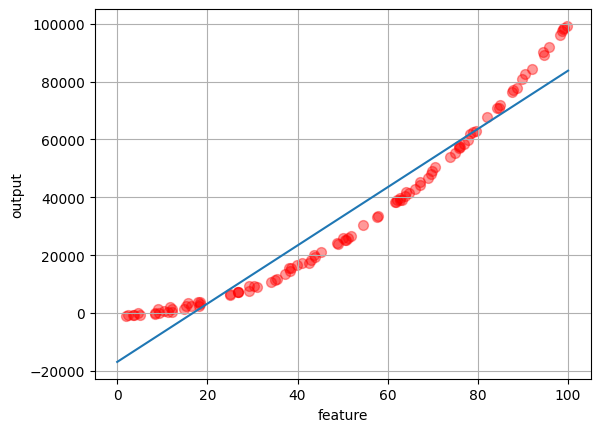

In [26]:
def generate_data_square_feature(a, b, xmin, xmax, N, noise):
    x = np.random.uniform(low=xmin, high=xmax, size=(N,))
    y = [a*i**2+b + np.random.uniform(low = -noise, high=noise) for i in x]
    
    return pd.DataFrame({"feature": x, "output":y})

data_square = generate_data_square_feature(10, 10, 0, 100, 100, 1000)
display(data_square.head())
data_square.plot(kind='scatter',x='feature',y='output',grid=True,s=50,color='red', alpha=0.4)

model = LinearRegression()
model.fit(pd.DataFrame(data_square.feature), data_square.output)
x_predicts = np.linspace(0,100,100)
predicts = model.predict(x_predicts.reshape(-1, 1))
plt.plot(x_predicts, predicts)


# y = w0 + w1 * x1 + w2 * x2 wat als x2 = x1^2  -> y = w0 + w1 * x1 + w2 * x1^2

Dit komt omdat ons huidige model te eenvoudig is en niet in staat is om de kwadratisch verband te modelleren.
Een oplossing hiervoor is om extra features te gaan toevoegen van een hogere orde, bijvoorbeeld een tweede feature die het kwadraat is van de eerste feature.

/usr/local/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([17.20456147,  9.86771088])

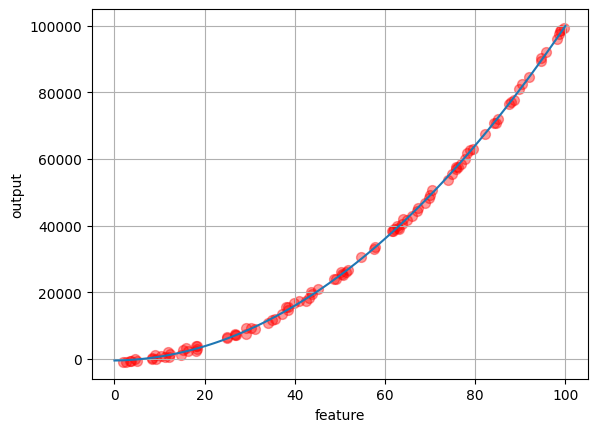

In [27]:
data_square["x2"] = data_square.feature**2

data_square.plot(kind='scatter',x='feature',y='output',grid=True,s=50,color='red', alpha=0.4)

model = LinearRegression()
model.fit(data_square[["feature","x2"]], data_square.output)
x_predicts = np.linspace(0,100, 100)
x_predicts = np.array([x_predicts, x_predicts**2]).T
predicts = model.predict(x_predicts)
plt.plot(x_predicts[:,0], predicts)
display(model.coef_)

Hetzelfde kan ook gedaan worden door features van nog hogere orde te introduceren (bijvoorbeeld derde of vierde graad).
Wel belangrijk is om erop te letten wat er gebeurt net buiten het bereik van je data, bijvoorbeeld in dit geval gaat het voor negatieve getallen terug beginnen stijgen wat niet altijd het verwachte resultaat is.

Er bestaan ook geautomatiseerde methoden om deze features van hogere orde toe te voegen.
Door gebruik te maken van de PolynomialFeatures functionaliteit in sklearn kan men alle features van een willekeurige graad toevoegen.
Let op, dat hierdoor ook alle combinaties ook toegevoegd worden dus voor de features "a" en "b" en voor een gewenste graad 3 komen deze features uiteindelijk in de dataset terecht: $a, a^2, a^3, b, ab, a^2b, b^2, ab^2, b^3$.
Het is dus duidelijk dat het aantal features zeer snel kan stijgen dus wees voorzichtig met de gekozen graad.
Onderstaande code is een voorbeeld van deze automatische manier om features toe te voegen:

In [28]:
graad = 3
poly = PolynomialFeatures(graad)
poly.fit(data_3)
display(data_3.shape)
X_train_poly = poly.transform(data_3)
X_train_poly.shape

(1000, 4)

(1000, 35)

### Extra features

Buiten de standaard features kan je ook extra features bedenken, zoals:
* De oppervlakte van het huis op basis van de lengte en breedte
* Uit start- en eindpunt de afstand halen
* Uit een datum, de dag van de week of de maand halen.
* Gemiddelde helderheid van een beeld
* Contouren detecteren in een beeld

Elke van deze nieuwe features kan meer informatie geven aan het model om extra verbanden te zoeken.

## Underfitting

Underfitting treedt op wanneer het model de beschikbare training data niet kan modelleren en dus ook niet op de testdata.
Dit komt vaak omdat er ofwel te weinig data beschikbaar is voor het model of dat het model te eenvoudig is (denk aan het model zonder hogere-orde features hierboven).

## Overfitting

Dit is het tegenovergestelde probleem.
Het model leert in dit geval te veel over de trainingsinformatie waardoor de fout op de trainingsset zeer klein is maar de fout op de testset significant groter is dan die op de trainingsset.
Men kan zeggen dat het model in dit geval te complex is voor de beschikbare data waardoor ruis in de data ook geleerd wordt. 
Vooral Neurale Netwerken zijn hier heel gevoelig aan. 
Onderstaande toont een voorbeeld van een te complex model:

/usr/local/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


(0.0, 200.0)

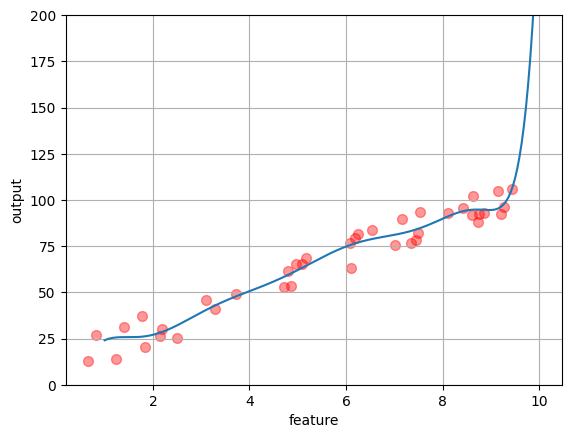

In [36]:
data_over = generate_data_single_feature(10, 10, 0, 10, 40, 10)
data_over.plot(kind='scatter',x='feature',y='output',grid=True,s=50,color='red', alpha=0.4)

graad = 10
poly = PolynomialFeatures(graad)
poly.fit(pd.DataFrame(data_over.feature))
X_train_over = poly.transform(pd.DataFrame(data_over.feature))

model = LinearRegression()
model.fit(X_train_over, data_over.output)

x_predicts = np.linspace(1,10,200)
x_predicts = poly.transform(x_predicts.reshape(-1, 1))
predicts = model.predict(x_predicts)

plt.plot(x_predicts[:,1], predicts)
plt.ylim(bottom=0, top=200)


In [31]:
model.score(X_train_over, data_over.output)

1.0

Er zijn twee manieren om dit op te lossen:
* Meer data lost meestal dit probleem wel op (maak hierboven eens ipv 4 samples 1000 samples aan als trainingsdata en de resultaten zullen helemaal anders zijn)
* Regularisatie

## Regularisatie

Methode om overfitting tegen te gaan en een goed evenwicht te zoeken tussen overfitting en underfitting.
Het werkt door een component toe te voegen aan de kostenfunctie die de regularisatieterm genoemd wordt.
De bedoeling van deze extra term is een kost toe te kennen aan het gebruik van hoge coefficienten zodat grote fluctuaties afgeraden worden tenzij ze een sterke daling van de kostenfunctie als resultaat hebben.
De uiteindelijke uitdrukking van de kostenfunctie is dan:

$ L(\pmb{w}) = \frac{1}{2N}\sum\limits_{i=1}^{N} (f_{\pmb{w}}(x^i) - y^i)^2 + \lambda R(\pmb{w})$

De $\lambda$ laat toe om de mate van regularisatie te tunen. 
Deze parameter (net zoals de graad van de hogere ordes) wordt een hyperparameter genoemd.
Een goede inschatting van deze hyperparameters kan een grote invloed hebben op het uiteindelijke resultaat van het model.
In python wordt de $\lambda$ parameter de $\alpha$ parameter genoemd maar de betekenis is net hetzelfde.

**L2-norm**

Hierbij is de regularisatieterm de som van het kwadraat van de gewichten. 
De code om deze vorm van regularisatie te gebruiken is:

/usr/local/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


(0.0, 200.0)

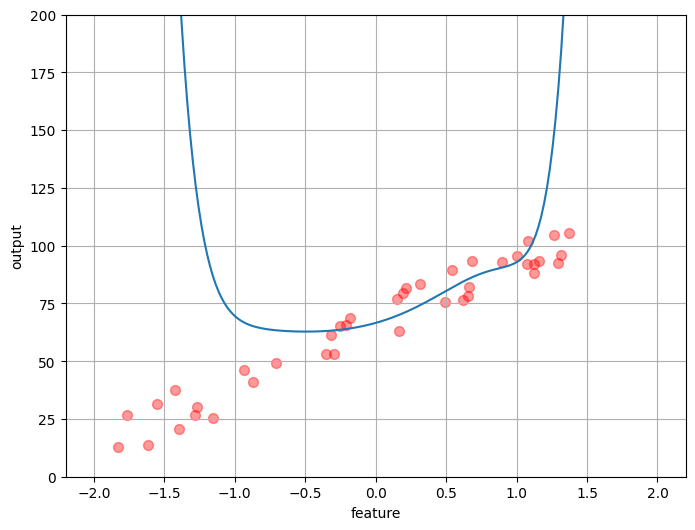

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_over)

model = Ridge(alpha=0.01, tol=0.0001, fit_intercept=True)
model.fit(X_scaled, data_over.output)
x_predicts = np.linspace(-2,2,200)
x_predicts = poly.transform(x_predicts.reshape(-1, 1))
predicts = model.predict(x_predicts)

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:,1], data_over['output'], s=50, color='red', alpha=0.4)
plt.xlabel('feature')
plt.ylabel('output')
plt.grid(True)
plt.plot(x_predicts[:,1], predicts)
plt.ylim(bottom=0, top=200)

Het is duidelijk dat door het toevoegen van het model, de sterke fluctuaties eruit zijn gehaald en het resultaat een heel stuk beter is. 
Merk ook op dat we hier onze features nog hebben genormalizeerd door de parameter mee te geven bij het aanmaken van het model.

**L1-Norm**

Een andere veel gebruikte regularisatieterm is de L1-Norm. 
Deze wordt berekend door het gemiddelde te nemen van de absolute waarden van de gewichten.
Het voordeel van deze term is dat er gewichten volledig op nul kunnen gezet worden indien ze niet bijdragen tot het voorspellen van de target.
De code om met deze term aan de slag te gaan is:

/usr/local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.609e+01, tolerance: 3.026e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


(0.0, 200.0)

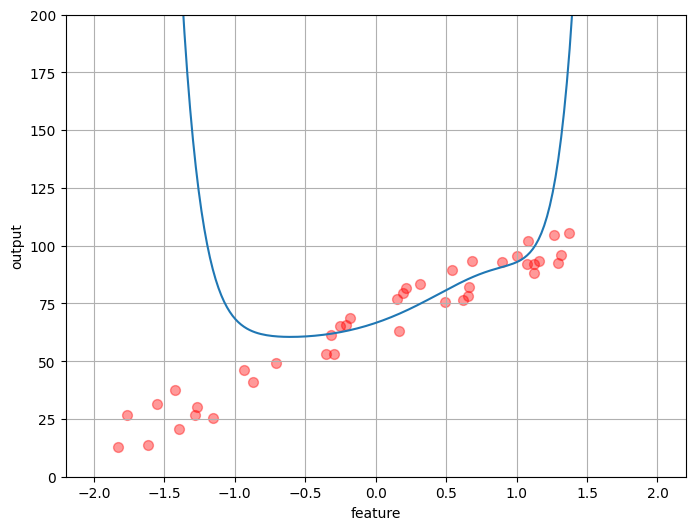

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_over)

model = Lasso(alpha=0.01, tol=0.0001, fit_intercept=True)
model.fit(X_scaled, data_over.output)
x_predicts = np.linspace(-2,2,200)
x_predicts = poly.transform(x_predicts.reshape(-1, 1))
predicts = model.predict(x_predicts)

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:,1], data_over['output'], s=50, color='red', alpha=0.4)
plt.xlabel('feature')
plt.ylabel('output')
plt.grid(True)
plt.plot(x_predicts[:,1], predicts)
plt.ylim(bottom=0, top=200)

Als afsluiter nog een tip om na te gaan of er under- of overfitting aanwezig is in het getrainde model.
Laat de target voor je trainingsdata voorspellen.
* Als zowel deze score als de testscore laag is, dan is er underfitting.
* Als de score van de trainingsdata hoog is maar die van de testdata laag, dan is er overfitting.

$R^2 = \frac{\sum\limits_{i=1}^{N}(\hat{y}_i-\bar{y})^2}{\sum\limits_{i=1}^{N}(y_i-\bar{y})^2}$

## Oefeningen:

Om de bovenstaande technieken verder in te oefenen kan de huisprijs voorspeld worden op basis van een aantal omgevingsfactoren met behulp van [deze dataset](https://www.kaggle.com/vikrishnan/boston-house-prices). 
Let er wel op dat de delimiter in deze dataset een spatie is in plaats van een komma dus dit gaat nog moeten meegegeven worden bij het inladen van het bestand.
Probeer minstens de volgende zaken uit:
* Maak een correlatiematrix aan en teken deze om de feature die de hoogste correlatie bevat te vinden.
* Maak voor deze correlatiematrix ook een [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html). Dit geeft voor elke combinatie van features een scatter plot die gebruikt kan worden om het verband tussen de verschillende features in te schatten.
* Probeer enkelvoudige lineare regressie uit door de huisprijs te voorspellen op basis van 1 feature. Wat is de hoogste score die je bekomt?
* Probeer meervoudige regressie uit om alle features te gebruiken? Wat is de impact op de score?
* Voeg de 2-orde feature toe voor de gekozen feature van de lineare regressie. Voer de regressie opnieuw uit en bestudeer de impact op de score van het model. Verklaar ook de impact.
* Zoek nu naar het beste model dat je kan vinden. Gebruik hiervoor alle features, hogere-orde features en regressie. Wat is de beste score die je bekomt en wat waren de gekozen hyperparameters hiervoor?